In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-model/dog_classification_efficientNetB0.h5
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091635_1634
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091635_4626
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091635_3916
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091635_386
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091635_3521
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091635_390
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091635_3072
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091635_4377
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091635_3822
/kaggle/input/stanford-dogs-dataset/annotations/Annotation/n02091635-otterhound/n02091

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [12]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
directory = "/kaggle/input/stanford-dogs-dataset/images/Images"
train_dataset = image_dataset_from_directory(directory,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            validation_split=0.2,
                                            subset="training",
                                            seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE,
                                                 validation_split=0.2,
                                                 subset="validation",
                                                 seed=42)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


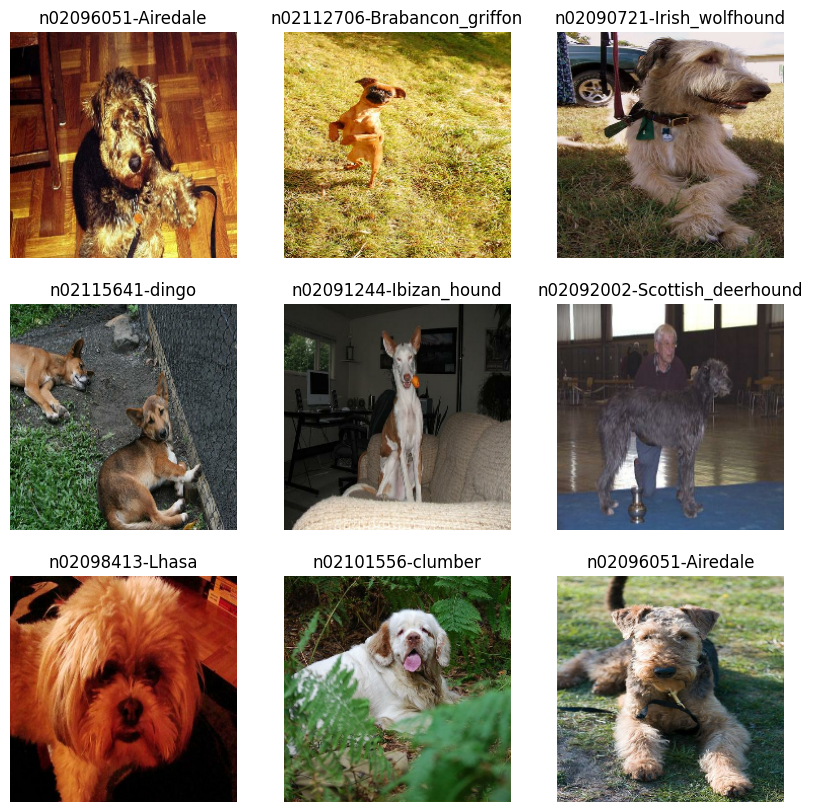

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(100):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmentor():
    
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(factor=0.2)
    ])
    
    return data_augmentation

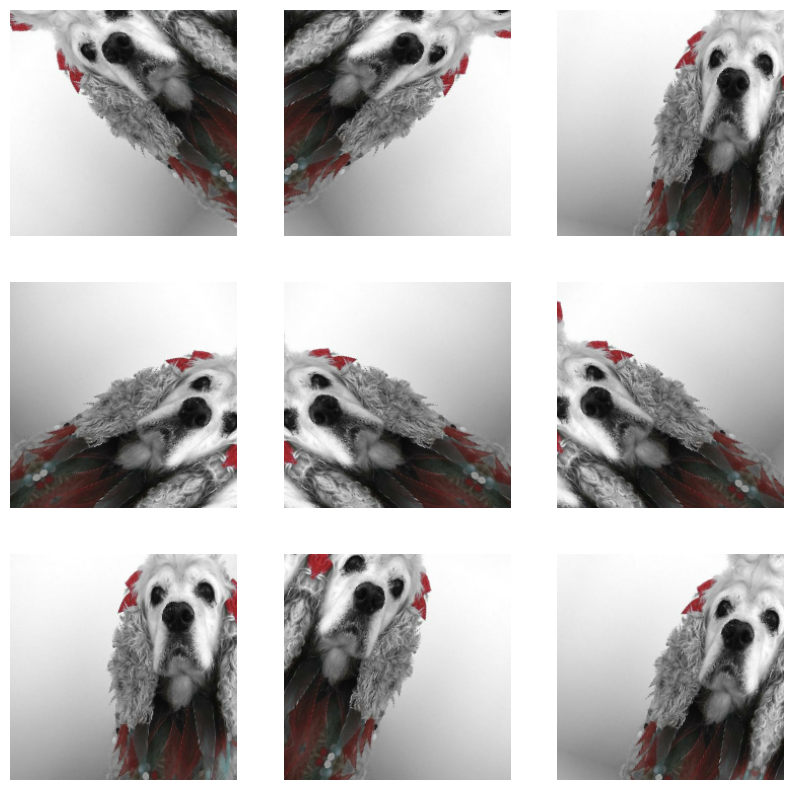

In [8]:
data_augmentation = data_augmentor()

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(aug_image[0]/255)
        plt.axis("off")

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = EfficientNetV2B0(input_shape=IMG_SHAPE,include_top=True,weights='imagenet')

29403144/29403144 [==============================] - 0s 0us/step


In [18]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.efficientnet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n02113624', 'toy_poodle', 0.5621074),
  ('n02113712', 'miniature_poodle', 0.24072982)],
 [('n02091244', 'Ibizan_hound', 0.79726076),
  ('n02115641', 'dingo', 0.09470365)],
 [('n02099849', 'Chesapeake_Bay_retriever', 0.9194969),
  ('n02099601', 'golden_retriever', 0.012173708)],
 [('n02094433', 'Yorkshire_terrier', 0.506662),
  ('n02097658', 'silky_terrier', 0.1965899)],
 [('n02108915', 'French_bulldog', 0.8899453),
  ('n02096585', 'Boston_bull', 0.006792594)],
 [('n02098105', 'soft-coated_wheaten_terrier', 0.9007329),
  ('n02095570', 'Lakeland_terrier', 0.041466974)],
 [('n02093647', 'Bedlington_terrier', 0.9297926),
  ('n02113799', 'standard_poodle', 0.013427289)],
 [('n02102177', 'Welsh_springer_spaniel', 0.8452767),
  ('n02088238', 'basset', 0.057682924)],
 [('n02105162', 'malinois', 0.8478974),
  ('n02106662', 'German_shepherd', 0.058813244)],
 [('n02105412', 'kelpie', 0.29361045),
  ('n02105056', 'groenendael', 0.09262246)],
 [('n02101006', 'Gordon_setter', 0.95987326),
  ('n0

In [19]:
def dog_model(image_shape=IMG_SIZE, data_augmentation=data_augmentor()):
    
    input_shape = image_shape + (3,)
    
    base_model = EfficientNetV2B0(input_shape=input_shape,
                                include_top=False,
                                weights="imagenet")
    
    base_model.trainable = False
    
    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    
    x = GlobalAvgPool2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    
    outputs = Dense(units=120, activation="softmax")(x)
    
    model = Model(inputs, outputs)
    return model

In [20]:
model2 = dog_model(IMG_SIZE)

24274472/24274472 [==============================] - 0s 0us/step


In [21]:
base_lr = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=["accuracy"])

In [22]:
initial_epochs = 20
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/20
258/258 [==============================] - 51s 161ms/step - loss: 1.3846 - accuracy: 0.6503 - val_loss: 0.4735 - val_accuracy: 0.8494
Epoch 2/20
258/258 [==============================] - 32s 121ms/step - loss: 0.7731 - accuracy: 0.7637 - val_loss: 0.4311 - val_accuracy: 0.8635
Epoch 3/20
258/258 [==============================] - 31s 119ms/step - loss: 0.6589 - accuracy: 0.7947 - val_loss: 0.4332 - val_accuracy: 0.8652
Epoch 4/20
258/258 [==============================] - 31s 119ms/step - loss: 0.5961 - accuracy: 0.8150 - val_loss: 0.4325 - val_accuracy: 0.8671
Epoch 5/20
258/258 [==============================] - 31s 119ms/step - loss: 0.5377 - accuracy: 0.8268 - val_loss: 0.4409 - val_accuracy: 0.8625
Epoch 6/20
258/258 [==============================] - 31s 120ms/step - loss: 0.4868 - accuracy: 0.8454 - val_loss: 0.4415 - val_accuracy: 0.8598
Epoch 7/20
258/258 [==============================] - 31s 119ms/step - loss: 0.4633 - accuracy: 0.8487 - val_loss: 0.4566 - val_ac

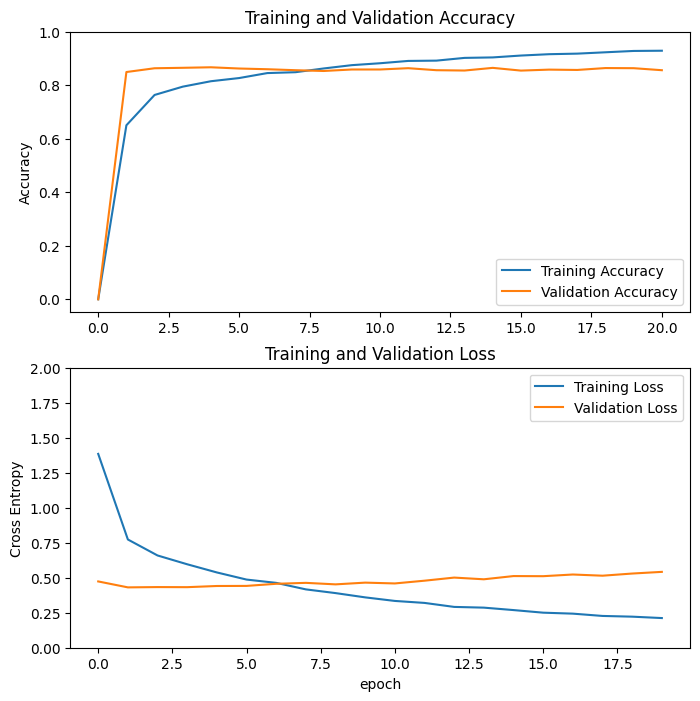

In [23]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Hyper-Tuning

In [24]:
base_model = model2.layers[2]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 200

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
metrics = ["accuracy"]

model2.compile(optimizer=optimizer, loss=loss_func, metrics=metrics)


Number of layers in the base model:  270


In [25]:
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_finetune = model2.fit(train_dataset, epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=validation_dataset)

Epoch 20/40
258/258 [==============================] - 62s 167ms/step - loss: 0.5299 - accuracy: 0.8261 - val_loss: 0.7285 - val_accuracy: 0.7884
Epoch 21/40
258/258 [==============================] - 41s 156ms/step - loss: 0.3662 - accuracy: 0.8786 - val_loss: 0.7711 - val_accuracy: 0.7988
Epoch 22/40
258/258 [==============================] - 41s 157ms/step - loss: 0.2984 - accuracy: 0.9018 - val_loss: 0.7942 - val_accuracy: 0.7976
Epoch 23/40
258/258 [==============================] - 41s 157ms/step - loss: 0.2634 - accuracy: 0.9155 - val_loss: 0.7176 - val_accuracy: 0.7998
Epoch 24/40
258/258 [==============================] - 41s 158ms/step - loss: 0.2253 - accuracy: 0.9258 - val_loss: 0.8882 - val_accuracy: 0.7760
Epoch 25/40
258/258 [==============================] - 41s 157ms/step - loss: 0.1956 - accuracy: 0.9355 - val_loss: 0.8211 - val_accuracy: 0.7911
Epoch 26/40
258/258 [==============================] - 41s 157ms/step - loss: 0.1789 - accuracy: 0.9411 - val_loss: 0.8826 -

In [26]:
acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']

loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']

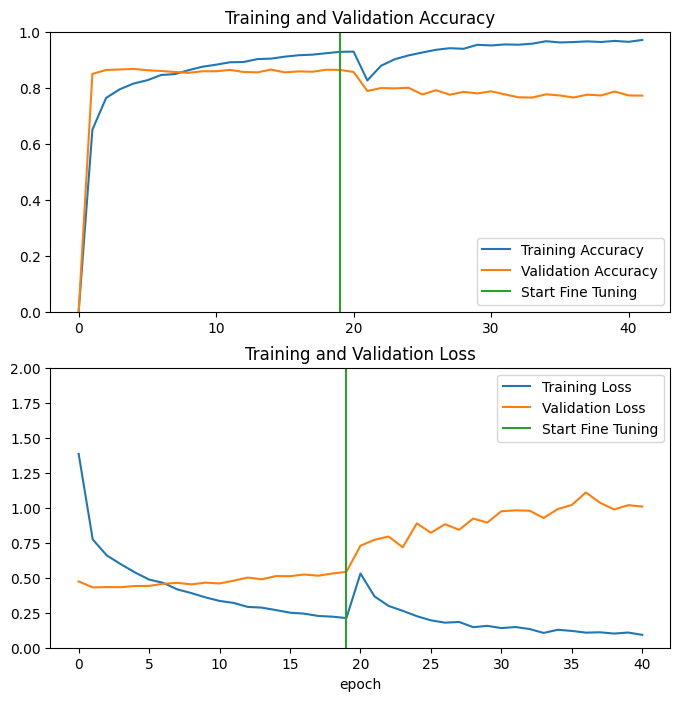

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save("Dog_classifier.h5")